# Simple synthetic test to compare Steepest Descent to Newton's method

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

## Using Gauss-Newton to impose smoothness


$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[ \mathbf{A}^T \mathbf{A} + \mu \mathbf{R}^T \mathbf{R} \right]^{-1} 
\left[ \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)] - \mu \mathbf{R}^T \mathbf{R}\mathbf{p}^k \right]
$$


Is there a difference between both methods? We've seen from the `moho-inversion-class.ipynb` notebook that the computation time is practically the same. If there is a difference, which is better?

## Create a synthetic model to test both methods

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import multiprocessing
import time
from IPython.display import Image
import matplotlib.pyplot as plt
from fatiando.inversion import Smoothness2D
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical, make_mesh, cross_validation

In [2]:
print(fatiando.__version__)

d3a8f4acd29a5377ccbd45c717863b909a8a0a1c


In [3]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

Define the computation grid.

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (20, 60, -40, 40)
lat, lon, h = gridder.regular(area, shape, z=50e3)

In [5]:
# Make a checkerboard relief undulating along the -35km height reference
f = 0.15
reference = -35e3
relief = 10e3*np.sin(1.5*f*lon)*np.cos(f*lat) + reference
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [6]:
model = make_mesh(area, shape, relief, reference)
model.addprop('density', density)

In [7]:
def plot_result_3d(moho, fname):
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

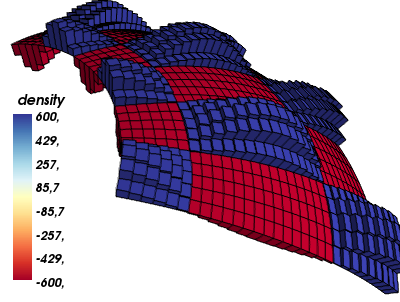

In [8]:
plot_result_3d(model, 'simple-synthetic-model.png')

In [9]:
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 5, seed=0)

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


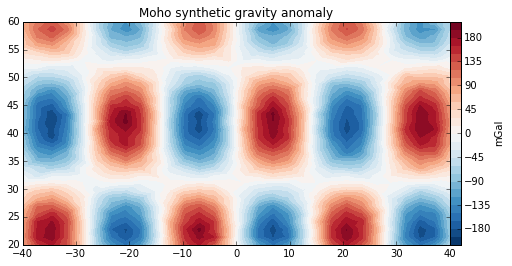

In [10]:
plt.figure(figsize=(9, 4))
plt.title('Moho synthetic gravity anomaly')
plt.tricontourf(lon, lat, gz, 30, cmap='RdBu_r')
plt.colorbar(pad=0).set_label('mGal')

## Inversion setup

In [11]:
# Make a mesh
mesh = model.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
initial = np.ones(mesh.size)*(mesh.reference - 30e3)

In [12]:
misfit = MohoGravityInvSpherical(lat, lon, h, gz, mesh)
regul = Smoothness2D(mesh.shape)

In [13]:
def plot_result_maps(solver):
    predicted = solver[0].predicted()
    residuals = solver[0].residuals()
    moho = solver.estimate_
    plt.figure(figsize=(9, 4))
    plt.title('Observed (color) and predicted (contour) data')
    plt.axis('scaled')
    levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
    plt.colorbar(pad=0).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels)
    plt.figure()
    plt.title('Residuals | mean={:.3f} std={:.3f}'.format(residuals.mean(), residuals.std()))
    plt.hist(residuals, bins=20)
    plt.figure(figsize=(9, 4))
    plt.title("Estimated Moho depth")
    plt.axis('scaled')
    plt.pcolormesh(moho.lons, moho.lats, -0.001*moho.relief.reshape(moho.shape), cmap='Blues_r')
    plt.colorbar(pad=0.01).set_label('km')
    plt.xlim(moho.lons.min(), moho.lons.max())
    plt.ylim(moho.lats.min(), moho.lats.max())

## Cross-validation

I'll use cross-validation to determine the optimal value of the regularization parameter.
The way this works is:

1. Create a separate dataset that will be used to check our solutions (the test dataset)
2. Run the inversion on the observed data for each value of the regularization parameter
3. For each solution, calculate the predicted data for the **test dataset** and the corresponding Residual Mean Square (RMS) error.
4. Choose the solution with the smallest RMS value for the test dataset.    

First, create the test data. I'll use a regular grid as well but at a lower height. This could be obtained from the same spherical harmonic model.

In [14]:
test_shape = [int(s*1.2) for s in shape]
print(test_shape)
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors

[36, 36]


Make a solver using the original mesh but with the test data (ignore the warning).

In [15]:
test_set = MohoGravityInvSpherical(test_lat, test_lon, test_h, test_data, mesh)

moho.py:71: RuntimeWarning: The mesh size (900) is different from the data size (1296). The mesh elements should be below each data point. Make sure you know what you're doing.
  warnings.warn(msg, RuntimeWarning)


## Steepest Descent

In [16]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

In [17]:
steep_config = dict(method='steepest', initial=initial, tol=0.1, maxit=10, linesearch=False)

In [18]:
%time results = cross_validation(misfit, regul, regul_params, steep_config, test_set, njobs=ncpu)

CPU times: user 66.2 ms, sys: 25.7 ms, total: 91.9 ms
Wall time: 57.6 s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:447: RuntimeWarning: Exited because maximum iterations reached. Might not

Unpack the results and plot the cross-validation data.

In [19]:
ibest, steep, steep_scores, solvers = results

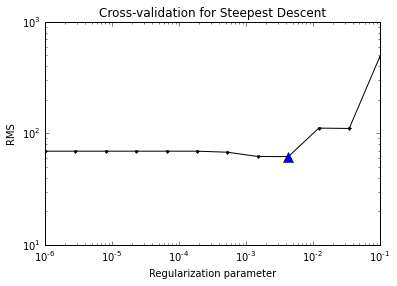

In [20]:
plt.figure()
plt.plot(regul_params, steep_scores, '.-k')
plt.plot(regul_params[ibest], steep_scores[ibest], '^b', markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Regularization parameter')
plt.ylabel('RMS')
plt.title('Cross-validation for {}'.format(steep.stats_['method']))

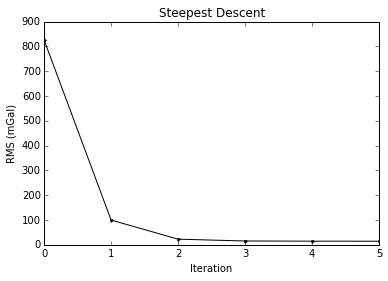

In [21]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(steep.stats_['objective'])/np.sqrt(misfit.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_xlabel('Iteration')
ax1.set_title(steep.stats_['method'])

/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


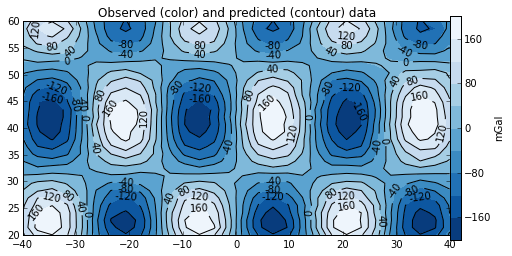

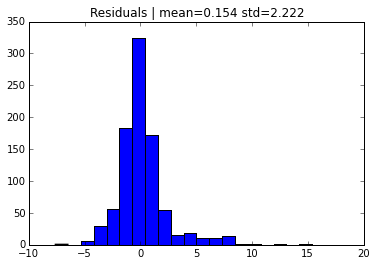

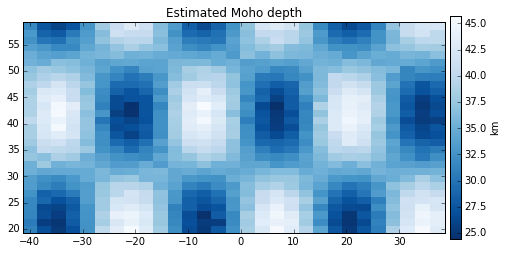

In [22]:
plot_result_maps(steep)

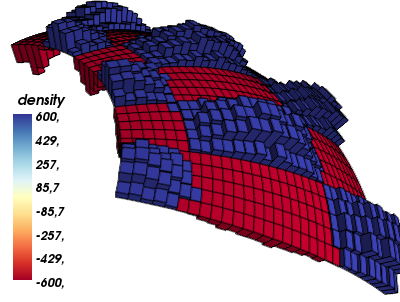

In [23]:
plot_result_3d(steep.estimate_, 'simple-synthetic-steepest.png')

**Notice that the solution is still not properly smooth.** 
So it seems that using only the gradient of the smoothness regularization with Steepest Descent is not enough to fully smooth the solution. The results in Santos et al 2015 are smooth, though. Maybe that's because they start out with a regularized solution from the start.

## Newton

In [24]:
regul_params = np.logspace(-6, -1, 12)
regul_params

array([  1.00000000e-06,   2.84803587e-06,   8.11130831e-06,
         2.31012970e-05,   6.57933225e-05,   1.87381742e-04,
         5.33669923e-04,   1.51991108e-03,   4.32876128e-03,
         1.23284674e-02,   3.51119173e-02,   1.00000000e-01])

In [25]:
newton_config = dict(method='newton', initial=initial, tol=0.1, maxit=10)

In [26]:
%time results = cross_validation(misfit, regul, regul_params, newton_config, test_set, njobs=ncpu)

CPU times: user 51.5 ms, sys: 45.2 ms, total: 96.6 ms
Wall time: 1min 5s


/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)
/home/leo/bin/anaconda/envs/mohoinv/lib/python2.7/site-packages/fatiando/inversion/optimization.py:185: RuntimeWarning: Exited because maximum iterations reached. Might not

In [27]:
ibest, newton, newton_scores, solvers = results

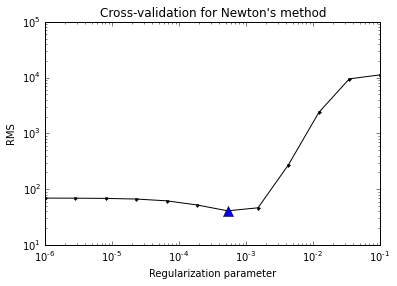

In [28]:
plt.figure()
plt.plot(regul_params, newton_scores, '.-k')
plt.plot(regul_params[ibest], newton_scores[ibest], '^b', markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Regularization parameter')
plt.ylabel('RMS')
plt.title('Cross-validation for {}'.format(newton.stats_['method']))

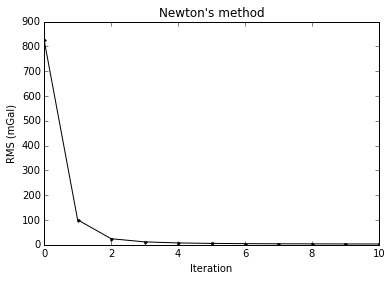

In [29]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(newton.stats_['objective'])/np.sqrt(misfit.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_xlabel('Iteration')
ax1.set_title(newton.stats_['method'])

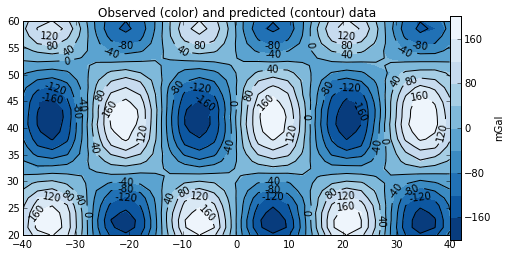

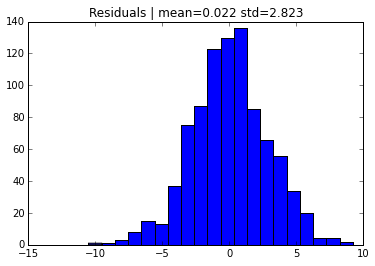

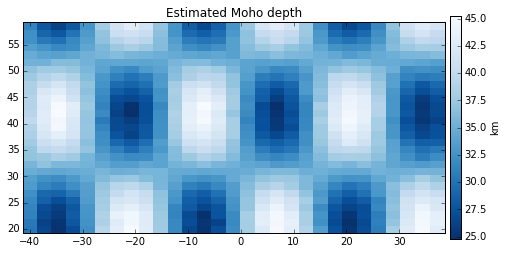

In [30]:
plot_result_maps(newton)

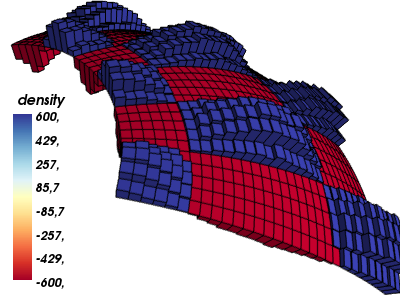

In [31]:
plot_result_3d(newton.estimate_, 'simple-synthetic-newton.png')

This is an over-regularized solution.

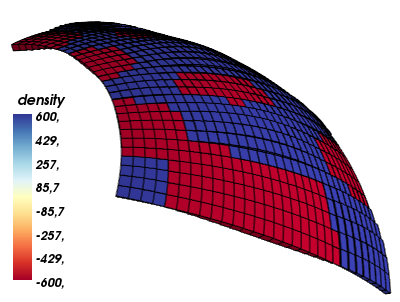

In [32]:
plot_result_3d(solvers[-2].estimate_, 'simple-synthetic-newton.png')

And here is an under-regularized.

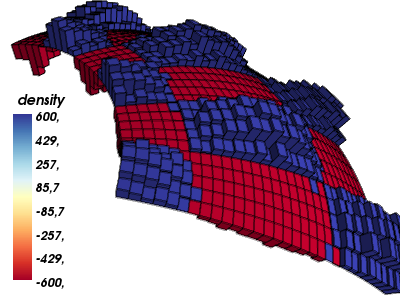

In [33]:
plot_result_3d(solvers[0].estimate_, 'simple-synthetic-newton.png')